In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import pydicom
#import missing_values_table
import os
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from IPython.display import display_html
from keras.preprocessing.image import ImageDataGenerator
import plotly.express as px
import random
from glob import glob
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from cv2 import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
#import efficientnet.tfkeras as efn
from sklearn.utils import class_weight
from sklearn.metrics import roc_auc_score
#from livelossplot import PlotLossesKeras
from tensorflow.keras.models import  Sequential, Model, load_model
#from livelossplot.keras import PlotLossesCallback
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten,BatchNormalization,Activation

from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers as L

In [103]:
# Directory
directory = '../input/siim-isic-melanoma-classification'

# Import the 2 csv s
df_train = pd.read_csv(directory + '/train.csv')
df_test = pd.read_csv(directory + '/test.csv')

print('Train has {:,} rows and Test has {:,} rows.'.format(len(df_train), len(df_test)))

Train has 33,126 rows and Test has 10,982 rows.


In [104]:
df1_styler = df_train.head().style.set_table_attributes("style='display:inline'").set_caption('Head Train Data')
df2_styler = df_test.head().style.set_table_attributes("style='display:inline'").set_caption('Head Test Data')

display_html(df1_styler._repr_html_() + df2_styler._repr_html_(), raw=True)

Head Train Data 
 
 
   
 image_name 
 patient_id 
 sex 
 age_approx 
 anatom_site_general_challenge 
 diagnosis 
 benign_malignant 
 target 
 
 
 
 
 0 
 ISIC_2637011 
 IP_7279968 
 male 
 45.000000 
 head/neck 
 unknown 
 benign 
 0 
 
 
 1 
 ISIC_0015719 
 IP_3075186 
 female 
 45.000000 
 upper extremity 
 unknown 
 benign 
 0 
 
 
 2 
 ISIC_0052212 
 IP_2842074 
 female 
 50.000000 
 lower extremity 
 nevus 
 benign 
 0 
 
 
 3 
 ISIC_0068279 
 IP_6890425 
 female 
 45.000000 
 head/neck 
 unknown 
 benign 
 0 
 
 
 4 
 ISIC_0074268 
 IP_8723313 
 female 
 55.000000 
 upper extremity 
 unknown 
 benign 
 0 
 
 
 

 
 Head Test Data 
 
 
   
 image_name 
 patient_id 
 sex 
 age_approx 
 anatom_site_general_challenge 
 
 
 
 
 0 
 ISIC_0052060 
 IP_3579794 
 male 
 70.000000 
 nan 
 
 
 1 
 ISIC_0052349 
 IP_7782715 
 male 
 40.000000 
 lower extremity 
 
 
 2 
 ISIC_0058510 
 IP_7960270 
 female 
 55.000000 
 torso 
 
 
 3 
 ISIC_0073313 
 IP_6375035 
 female 
 50.000000 
 torso 
 
 
 4 
 ISIC_0073502 
 IP_0589375 
 female 
 45.000000 
 lower extremity

In [105]:
list(os.listdir('../input/siim-isic-melanoma-classification'))

['sample_submission.csv',
 'jpeg',
 'tfrecords',
 'train.csv',
 'test.csv',
 'test',
 'train']

In [106]:
df_train.dtypes

image_name                        object
patient_id                        object
sex                               object
age_approx                       float64
anatom_site_general_challenge     object
diagnosis                         object
benign_malignant                  object
target                             int64
dtype: object

In [107]:
df_test.dtypes

image_name                        object
patient_id                        object
sex                               object
age_approx                       float64
anatom_site_general_challenge     object
dtype: object

In [108]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [109]:
missing_values = missing_values_table(df_train)
missing_values.head()

Your selected dataframe has 8 columns.
There are 3 columns that have missing values.


,Missing Values,% of Total Values
anatom_site_general_challenge,527,1.6
age_approx,68,0.2
sex,65,0.2


In [110]:
missing_values = missing_values_table(df_test)
missing_values.head()

Your selected dataframe has 5 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
anatom_site_general_challenge,351,3.2


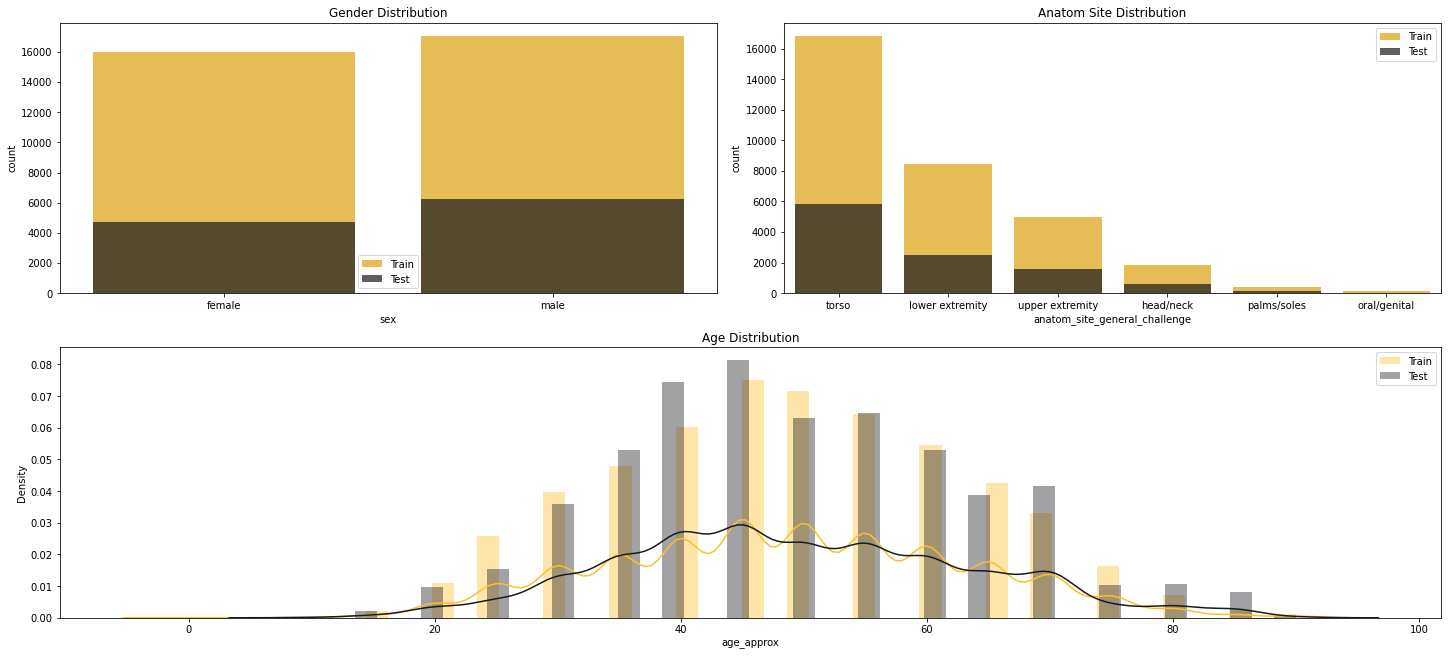

In [111]:
# Creating a customized chart and giving in figsize etc.

fig = plt.figure(constrained_layout=True, figsize=(20, 9))

# Creating a grid:

grid = gridspec.GridSpec(ncols=4, nrows=2, figure=fig)

ax1 = fig.add_subplot(grid[0, :2])

# Set the title.

ax1.set_title('Gender Distribution')

sns.countplot(df_train.sex.sort_values(ignore_index=True),
              alpha=0.9,
              ax=ax1,
              color='#fdc029',
              label='Train')
sns.countplot(df_test.sex.sort_values(ignore_index=True),
              alpha=0.7,
              ax=ax1,
              color='#171820',
              label='Test')
ax1.legend()

# Customizing the second grid.

ax2 = fig.add_subplot(grid[0, 2:])

# Plot the countplot.

sns.countplot(df_train.anatom_site_general_challenge,
              alpha=0.9,
              ax=ax2,
              color='#fdc029',
              label='Train',
              order=df_train['anatom_site_general_challenge'].value_counts().index)
sns.countplot(df_test.anatom_site_general_challenge,
              alpha=0.7,
              ax=ax2,
              color='#171820',
              label='Test',
              order=df_test['anatom_site_general_challenge'].value_counts().index), ax2.set_title(
                  'Anatom Site Distribution')

ax2.legend()

# Customizing the third grid.

ax3 = fig.add_subplot(grid[1, :])

# Set the title.

ax3.set_title('Age Distribution')

# Plot the histogram.

sns.distplot(df_train.age_approx, ax=ax3, label='Train', color='#fdc029')
sns.distplot(df_test.age_approx, ax=ax3, label='Test', color='#171820')

ax3.legend()

plt.show()

In [112]:
# Double checking:

ids_train = df_train.anatom_site_general_challenge.values
ids_test = df_test.anatom_site_general_challenge.values
ids_train_set = set(ids_train)
ids_test_set = set(ids_test)

location_not_overlap = list(ids_train_set.symmetric_difference(ids_test_set))
n_overlap = len(location_not_overlap)
if n_overlap == 0:
    print(
        f'There are no different body parts  between train and test set...'
    )
else:
    print('There are some not overlapping values between train and test set!')

There are no different body parts  between train and test set...


In [113]:
# Filling age and sex with appropriate values.

df_train['sex'].fillna(df_train['sex'].mode()[0], inplace=True)

df_train['age_approx'].fillna(df_train['age_approx'].median(), inplace=True)

From all missing values, 518 are benign and 9 malignant.


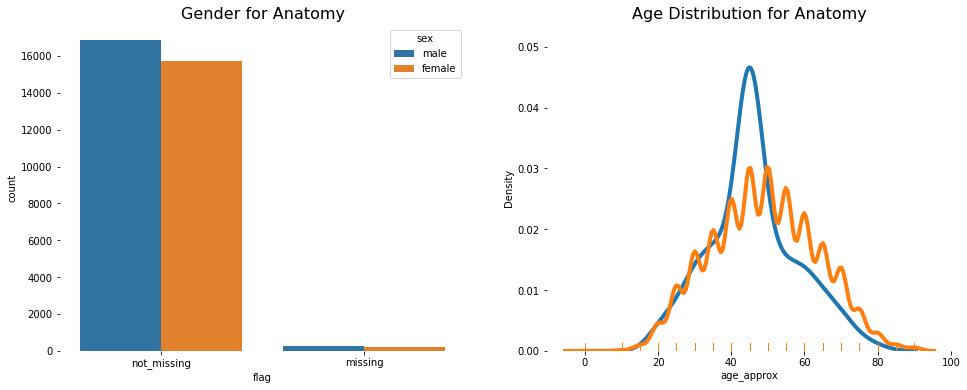

In [114]:
anatomy = df_train.copy()
anatomy['flag'] = np.where(df_train['anatom_site_general_challenge'].isna()==True, 'missing', 'not_missing')

# Figure
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6))

sns.countplot(anatomy['flag'], hue=anatomy['sex'], ax=ax1)

sns.distplot(anatomy[anatomy['flag'] == 'missing']['age_approx'], 
             hist=False, rug=True, label='Missing', ax=ax2, 
              kde_kws=dict(linewidth=4))
sns.distplot(anatomy[anatomy['flag'] == 'not_missing']['age_approx'], 
             hist=False, rug=True, label='Not Missing', ax=ax2, 
             kde_kws=dict(linewidth=4))

ax1.set_title('Gender for Anatomy', fontsize=16)
ax2.set_title('Age Distribution for Anatomy', fontsize=16)
sns.despine(left=True, bottom=True);

# Benign - malignant
ben_mal = anatomy[anatomy['flag'] == 'missing']['benign_malignant'].value_counts()
print('From all missing values, {} are benign and {} malignant.'.format(ben_mal[0], ben_mal[1]))

In [115]:
df_train['anatom_site_general_challenge'].fillna('torso', inplace = True)

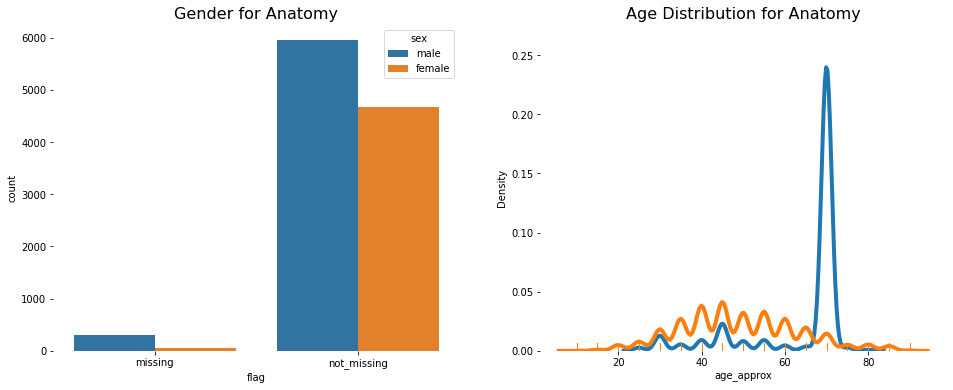

In [116]:
anatomy = df_test.copy()
anatomy['flag'] = np.where(df_test['anatom_site_general_challenge'].isna()==True, 'missing', 'not_missing')

# Figure
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6))

sns.countplot(anatomy['flag'], hue=anatomy['sex'], ax=ax1)

sns.distplot(anatomy[anatomy['flag'] == 'missing']['age_approx'],
             hist=False, rug=True, label='Missing', ax=ax2, 
              kde_kws=dict(linewidth=4, bw=0.1))

sns.distplot(anatomy[anatomy['flag'] == 'not_missing']['age_approx'], 
             hist=False, rug=True, label='Not Missing', ax=ax2, 
              kde_kws=dict(linewidth=4, bw=0.1))

ax1.set_title('Gender for Anatomy', fontsize=16)
ax2.set_title('Age Distribution for Anatomy', fontsize=16)
sns.despine(left=True, bottom=True);

In [117]:
# Select most frequent anatomy for age 70
value = df_test[df_test['age_approx'] == 70]['anatom_site_general_challenge'].value_counts().reset_index()['index'][0]
print(value)
# Impute the value
df_test['anatom_site_general_challenge'].fillna(value, inplace = True) 

torso


In [118]:
# Checking missing value counts:

print(
    f'Train missing value count: {df_train.isnull().sum().sum()}\nTest missing value count: {df_test.isnull().sum().sum()}'
)

Train missing value count: 0
Test missing value count: 0


In [119]:
print('Number of Duplicates in the Train Dataset= ' + str(df_train.duplicated().sum()))

Number of Duplicates in the Train Dataset= 0


In [120]:
print('Number of Duplicates in the Test Dataset= ' + str(df_train.duplicated().sum()))

Number of Duplicates in the Test Dataset= 0


## EDA - Let's take a look 🔎

### Target Variable:
1. Very HIGH class imbalance. We need to take this in consideration when Modeling.
2. Age distribution:
    * Benign: follows a normal distribution
    * Malignant: a little skewed to the left, with the peak oriented towards higher age values.

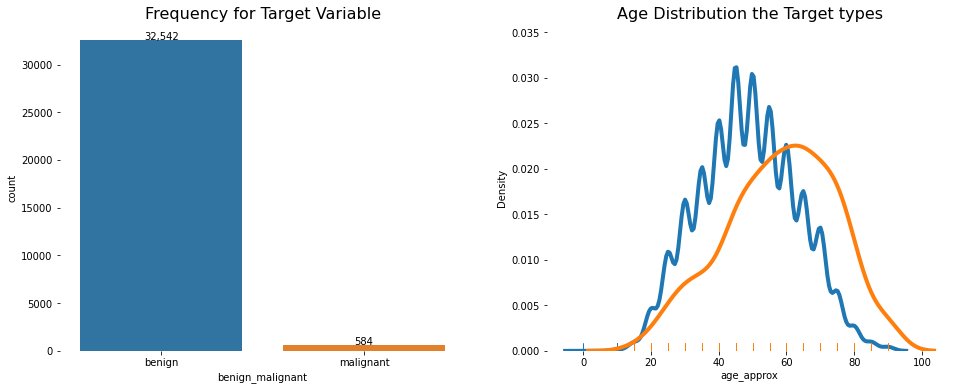

In [121]:
# Figure
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6))

a = sns.countplot(data = df_train, x = 'benign_malignant', 
                 ax=ax1)
b = sns.distplot(a = df_train[df_train['target']==0]['age_approx'], ax=ax2,
                 hist=False, rug=True, kde_kws=dict(linewidth=4), label='Benign')
c = sns.distplot(a = df_train[df_train['target']==1]['age_approx'], ax=ax2,
                 hist=False, rug=True, kde_kws=dict(linewidth=4), label='Malignant')

for p in a.patches:
    a.annotate(format(p.get_height(), ','), 
           (p.get_x() + p.get_width() / 2., 
            p.get_height()), ha = 'center', va = 'center', 
           xytext = (0, 4), textcoords = 'offset points')
    
ax1.set_title('Frequency for Target Variable', fontsize=16)
ax2.set_title('Age Distribution the Target types', fontsize=16)
sns.despine(left=True, bottom=True);

### Target and Genders:
1. There are more males than females in the dataset
2. However, the percentages are ~ the same

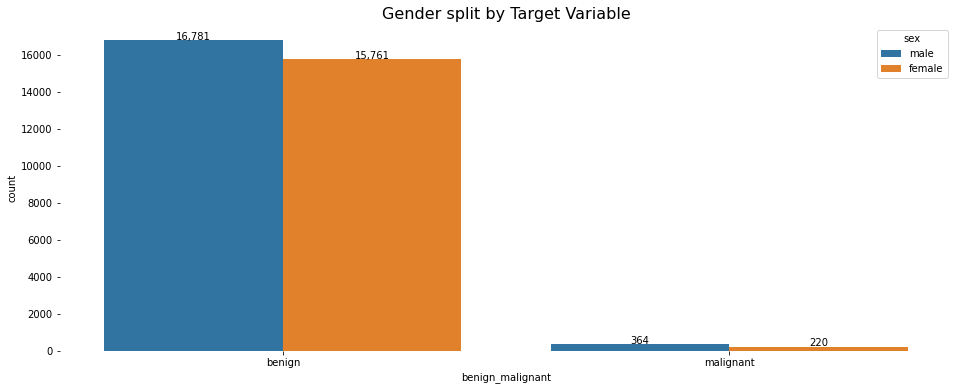

In [122]:
plt.figure(figsize=(16, 6))
a = sns.countplot(data=df_train, x='benign_malignant', hue='sex')

for p in a.patches:
    a.annotate(format(p.get_height(), ','), 
           (p.get_x() + p.get_width() / 2., 
            p.get_height()), ha = 'center', va = 'center', 
           xytext = (0, 4), textcoords = 'offset points')

plt.title('Gender split by Target Variable', fontsize=16)
sns.despine(left=True, bottom=True);

### Anatomy and Target
> Note: Distributions are about the same shape for both benign and malignant cases.

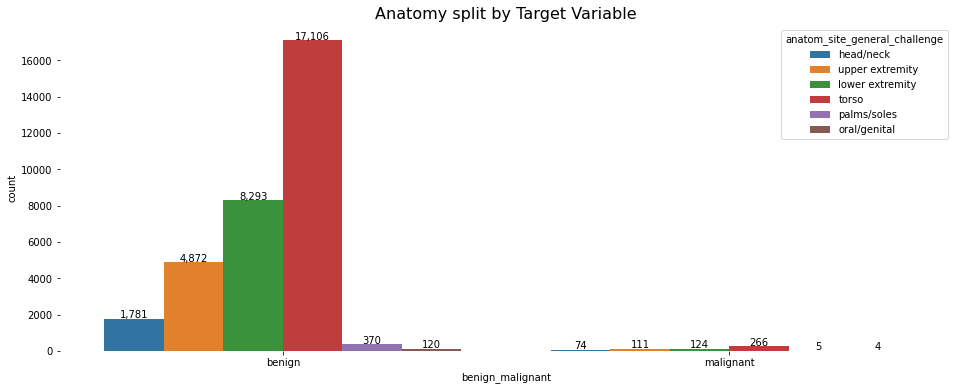

In [123]:
plt.figure(figsize=(16, 6))
a = sns.countplot(data=df_train, x='benign_malignant', hue='anatom_site_general_challenge')

for p in a.patches:
    a.annotate(format(p.get_height(), ','), 
           (p.get_x() + p.get_width() / 2., 
            p.get_height()), ha = 'center', va = 'center', 
           xytext = (0, 4), textcoords = 'offset points')

plt.title('Anatomy split by Target Variable', fontsize=16)
sns.despine(left=True, bottom=True);

### Diagnosis and Target

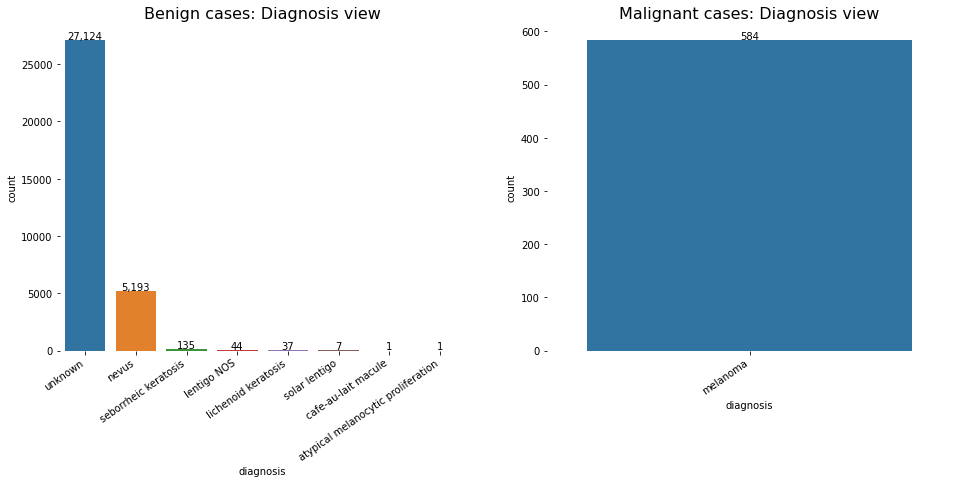

In [124]:
# Figure
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6))

a = sns.countplot(df_train[df_train['target']==0]['diagnosis'], ax=ax1)
b = sns.countplot(df_train[df_train['target']==1]['diagnosis'], ax=ax2)

a.set_xticklabels(a.get_xticklabels(), rotation=35, ha="right")
b.set_xticklabels(b.get_xticklabels(), rotation=35, ha="right")

for p in a.patches:
    a.annotate(format(p.get_height(), ','), 
           (p.get_x() + p.get_width() / 2., 
            p.get_height()), ha = 'center', va = 'center', 
           xytext = (0, 4), textcoords = 'offset points')
    
for p in b.patches:
    b.annotate(format(p.get_height(), ','), 
           (p.get_x() + p.get_width() / 2., 
            p.get_height()), ha = 'center', va = 'center', 
           xytext = (0, 4), textcoords = 'offset points')
    
ax1.set_title('Benign cases: Diagnosis view', fontsize=16)
ax2.set_title('Malignant cases: Diagnosis view', fontsize=16)
sns.despine(left=True, bottom=True);

# A General Look With Sunburst Chart

Sunburst chart is pretty cool looking fella I'd say. It also giving lots of basic information to us. Let's see...

- Only 2% of our targets are malignant
- On malignant images males are dominant with 62% 
- Gender wise benign images are more balance 52-48% male female ratio
- Malignant image scan locations differs based on the patients gender:
    - Meanwhile the torso is most common location in males it's almost half of the scans meanwhile in females it's 39%
    - Lower extremity is more common with female scans than males 18% males vs 26% females
    - Again upper extremity malignant scans is common with females than males (23- 17%)
- Benign image scan locations more similar between male and female patients.

In [125]:
# Plotting interactive sunburst:

fig = px.sunburst(data_frame=df_train,
                  path=['benign_malignant', 'sex', 'anatom_site_general_challenge'],
                  color='sex',
                  maxdepth=-1,
                  title='Sunburst Chart Benign/Malignant > Sex > anatom_site_general_challenge')

fig.update_traces(textinfo='label+percent parent')
fig.update_layout(margin=dict(t=0, l=0, r=0, b=0))
fig.show()

### Test Dataset Overview
> Distributions look ~ the same as in Train Data.

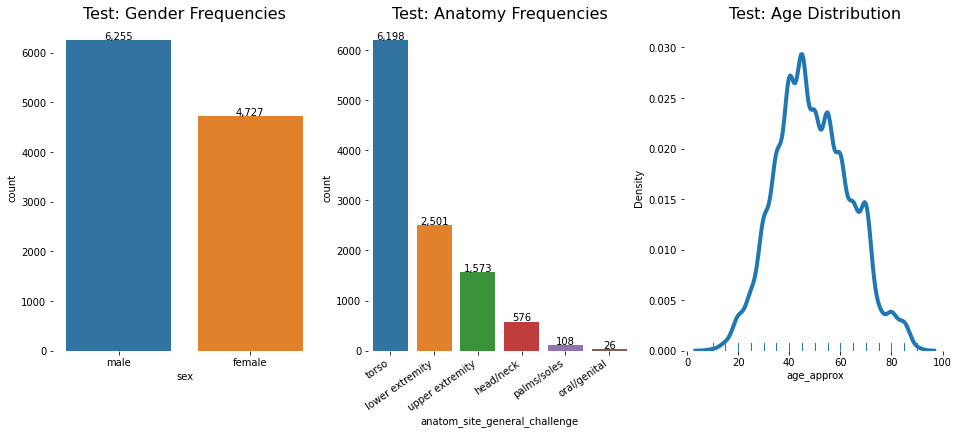

In [126]:
# Figure
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (16, 6))

a = sns.countplot(df_test['sex'], ax=ax1)
b = sns.countplot(df_test['anatom_site_general_challenge'], ax=ax2)
c = sns.distplot(a = df_test['age_approx'], ax=ax3,  
                 hist=False, rug=True, kde_kws=dict(linewidth=4))

for p in a.patches:
    a.annotate(format(p.get_height(), ','), 
           (p.get_x() + p.get_width() / 2., 
            p.get_height()), ha = 'center', va = 'center', 
           xytext = (0, 4), textcoords = 'offset points')
    
for p in b.patches:
    b.annotate(format(p.get_height(), ','), 
           (p.get_x() + p.get_width() / 2., 
            p.get_height()), ha = 'center', va = 'center', 
           xytext = (0, 4), textcoords = 'offset points')
    
b.set_xticklabels(b.get_xticklabels(), rotation=35, ha="right")

ax1.set_title('Test: Gender Frequencies', fontsize=16)
ax2.set_title('Test: Anatomy Frequencies', fontsize=16)
ax3.set_title('Test: Age Distribution', fontsize=16)
sns.despine(left=True, bottom=True);

# Unique Patients and Their Scan Images

It looks like we have multiple scan images per patient, actual unique patient counts are much lower than images on both datasets. We can get more information about patients age like when he had his first scan and his last scan. We can get interesting insights like:

- Most of the malignant results are found around first 20 scans. Of course there can be control scans after the diagnosis...
- Scan numbers are similar in first 100 scans but we have 200+ scan images for **one particular patient** in dataset, it's pretty interesting since we don't have this case in our training data. We should be careful about this and it can effect our model.
- Most of the malignant cases are under 20 images but in general we can say it's more likely to be malignant result if there are more scan images...

In [127]:
print(
    f'Number of unique Patient ID\'s in train set: {df_train.patient_id.nunique()}, Total: {df_train.patient_id.count()}\nNumber of unique Patient ID\'s in test set: {df_test.patient_id.nunique()}, Total: {df_test.patient_id.count()}'
)

Number of unique Patient ID's in train set: 2056, Total: 33126
Number of unique Patient ID's in test set: 690, Total: 10982


In [128]:
df_train['n_images'] = df_train.patient_id.map(df_train.groupby(['patient_id']).image_name.count())
df_test['n_images'] = df_test.patient_id.map(df_test.groupby(['patient_id']).image_name.count())

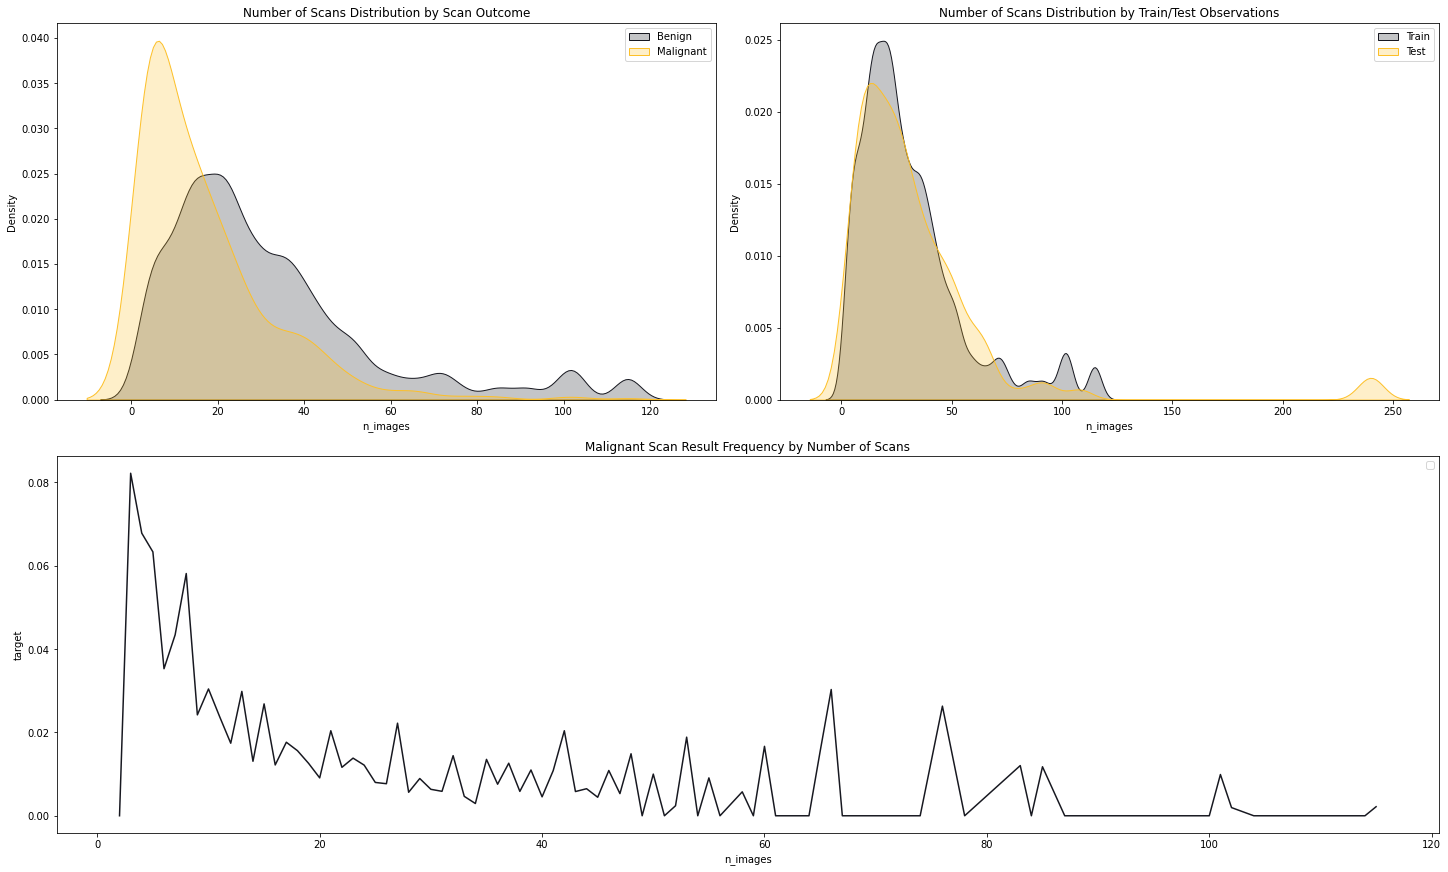

In [129]:


fig = plt.figure(constrained_layout=True, figsize=(20, 12))

# Creating a grid

grid = gridspec.GridSpec(ncols=4, nrows=2, figure=fig)

# Customizing the first grid.

ax1 = fig.add_subplot(grid[0, :2])

# Set the title.

ax1.set_title('Number of Scans Distribution by Scan Outcome')

# Plot

sns.kdeplot(df_train[df_train['target'] == 0]['n_images'],
            shade=True,
            ax=ax1,
            color='#171820',
            label='Benign')
sns.kdeplot(df_train[df_train['target'] == 1]['n_images'],
            shade=True,
            ax=ax1,
            color='#fdc029',
            label='Malignant')

ax1.legend()

# Customizing the second grid.

ax2 = fig.add_subplot(grid[0, 2:])

# Set the title.

ax2.set_title('Number of Scans Distribution by Train/Test Observations')

# Plot

sns.kdeplot(df_train.n_images, label='Train', shade=True, ax=ax2, color='#171820')
sns.kdeplot(df_test.n_images, label='Test', shade=True, ax=ax2, color='#fdc029')
ax2.legend()

# Customizing the third grid.

ax3 = fig.add_subplot(grid[1, :])

# Set the title.

ax3.set_title('Malignant Scan Result Frequency by Number of Scans')

# Plot

z = df_train.groupby('n_images')['target'].mean()
sns.lineplot(x=z.index, y=z, color='#171820', ax=ax3)
ax3.legend()

plt.show()

In [130]:
# === JPEG ===
# Create the paths
path_train = directory + '/jpeg/train/' + df_train['image_name'] + '.jpg'
path_test = directory + '/jpeg/test/' + df_test['image_name'] + '.jpg'

# Append to the original dataframes
df_train['path_jpeg'] = path_train
df_test['path_jpeg'] = path_test
df1_styler = df_train.head().style.set_table_attributes("style='display:inline'").set_caption('Head Train Data')
df2_styler = df_test.head().style.set_table_attributes("style='display:inline'").set_caption('Head Test Data')

display_html(df1_styler._repr_html_() + df2_styler._repr_html_(), raw=True)

Head Train Data 
 
 
   
 image_name 
 patient_id 
 sex 
 age_approx 
 anatom_site_general_challenge 
 diagnosis 
 benign_malignant 
 target 
 n_images 
 path_jpeg 
 
 
 
 
 0 
 ISIC_2637011 
 IP_7279968 
 male 
 45.000000 
 head/neck 
 unknown 
 benign 
 0 
 115 
 ../input/siim-isic-melanoma-classification/jpeg/train/ISIC_2637011.jpg 
 
 
 1 
 ISIC_0015719 
 IP_3075186 
 female 
 45.000000 
 upper extremity 
 unknown 
 benign 
 0 
 24 
 ../input/siim-isic-melanoma-classification/jpeg/train/ISIC_0015719.jpg 
 
 
 2 
 ISIC_0052212 
 IP_2842074 
 female 
 50.000000 
 lower extremity 
 nevus 
 benign 
 0 
 5 
 ../input/siim-isic-melanoma-classification/jpeg/train/ISIC_0052212.jpg 
 
 
 3 
 ISIC_0068279 
 IP_6890425 
 female 
 45.000000 
 head/neck 
 unknown 
 benign 
 0 
 22 
 ../input/siim-isic-melanoma-classification/jpeg/train/ISIC_0068279.jpg 
 
 
 4 
 ISIC_0074268 
 IP_8723313 
 female 
 55.000000 
 upper extremity 
 unknown 
 benign 
 0 
 20 
 ../input/siim-isic-melanoma-classification/jpeg/train/ISIC_0074268.jpg 
 
 
 

 
 Head Test Data 
 
 
   
 image_name 
 patient_id 
 sex 
 age_approx 
 anatom_site_general_challenge 
 n_images 
 path_jpeg 
 
 
 
 
 0 
 ISIC_0052060 
 IP_3579794 
 male 
 70.000000 
 torso 
 240 
 ../input/siim-isic-melanoma-classification/jpeg/test/ISIC_0052060.jpg 
 
 
 1 
 ISIC_0052349 
 IP_7782715 
 male 
 40.000000 
 lower extremity 
 46 
 ../input/siim-isic-melanoma-classification/jpeg/test/ISIC_0052349.jpg 
 
 
 2 
 ISIC_0058510 
 IP_7960270 
 female 
 55.000000 
 torso 
 28 
 ../input/siim-isic-melanoma-classification/jpeg/test/ISIC_0058510.jpg 
 
 
 3 
 ISIC_0073313 
 IP_6375035 
 female 
 50.000000 
 torso 
 38 
 ../input/siim-isic-melanoma-classification/jpeg/test/ISIC_0073313.jpg 
 
 
 4 
 ISIC_0073502 
 IP_0589375 
 female 
 45.000000 
 lower extremity 
 29 
 ../input/siim-isic-melanoma-classification/jpeg/test/ISIC_0073502.jpg

## Label Encoding
Transforming all categorical features un numerical.
> Note1: `sex`, `anatomy`, `diagnosis` need to be encoded.

> Note2: `benign_malignant` column will be dropped, as the information is already in the `target` column.

In [131]:
# === TRAIN ===
to_encode = ['sex', 'anatom_site_general_challenge', 'diagnosis']
encoded_all = []

label_encoder = LabelEncoder()

for column in to_encode:
    encoded = label_encoder.fit_transform(df_train[column])
    encoded_all.append(encoded)
    
df_train['sex'] = encoded_all[0]
df_train['anatom_site_general_challenge'] = encoded_all[1]
df_train['diagnosis'] = encoded_all[2]

if 'benign_malignant' in df_train.columns : df_train.drop(['benign_malignant'], axis=1, inplace=True)
    # === TEST ===
to_encode = ['sex', 'anatom_site_general_challenge']
encoded_all = []

label_encoder = LabelEncoder()

for column in to_encode:
    encoded = label_encoder.fit_transform(df_test[column])
    encoded_all.append(encoded)
    
df_test['sex'] = encoded_all[0]
df_test['anatom_site_general_challenge'] = encoded_all[1]
df1_styler = df_train.head().style.set_table_attributes("style='display:inline'").set_caption('Head Train Data')
df2_styler = df_test.head().style.set_table_attributes("style='display:inline'").set_caption('Head Test Data')

display_html(df1_styler._repr_html_() + df2_styler._repr_html_(), raw=True)

Head Train Data 
 
 
   
 image_name 
 patient_id 
 sex 
 age_approx 
 anatom_site_general_challenge 
 diagnosis 
 target 
 n_images 
 path_jpeg 
 
 
 
 
 0 
 ISIC_2637011 
 IP_7279968 
 1 
 45.000000 
 0 
 8 
 0 
 115 
 ../input/siim-isic-melanoma-classification/jpeg/train/ISIC_2637011.jpg 
 
 
 1 
 ISIC_0015719 
 IP_3075186 
 0 
 45.000000 
 5 
 8 
 0 
 24 
 ../input/siim-isic-melanoma-classification/jpeg/train/ISIC_0015719.jpg 
 
 
 2 
 ISIC_0052212 
 IP_2842074 
 0 
 50.000000 
 1 
 5 
 0 
 5 
 ../input/siim-isic-melanoma-classification/jpeg/train/ISIC_0052212.jpg 
 
 
 3 
 ISIC_0068279 
 IP_6890425 
 0 
 45.000000 
 0 
 8 
 0 
 22 
 ../input/siim-isic-melanoma-classification/jpeg/train/ISIC_0068279.jpg 
 
 
 4 
 ISIC_0074268 
 IP_8723313 
 0 
 55.000000 
 5 
 8 
 0 
 20 
 ../input/siim-isic-melanoma-classification/jpeg/train/ISIC_0074268.jpg 
 
 
 

 
 Head Test Data 
 
 
   
 image_name 
 patient_id 
 sex 
 age_approx 
 anatom_site_general_challenge 
 n_images 
 path_jpeg 
 
 
 
 
 0 
 ISIC_0052060 
 IP_3579794 
 1 
 70.000000 
 4 
 240 
 ../input/siim-isic-melanoma-classification/jpeg/test/ISIC_0052060.jpg 
 
 
 1 
 ISIC_0052349 
 IP_7782715 
 1 
 40.000000 
 1 
 46 
 ../input/siim-isic-melanoma-classification/jpeg/test/ISIC_0052349.jpg 
 
 
 2 
 ISIC_0058510 
 IP_7960270 
 0 
 55.000000 
 4 
 28 
 ../input/siim-isic-melanoma-classification/jpeg/test/ISIC_0058510.jpg 
 
 
 3 
 ISIC_0073313 
 IP_6375035 
 0 
 50.000000 
 4 
 38 
 ../input/siim-isic-melanoma-classification/jpeg/test/ISIC_0073313.jpg 
 
 
 4 
 ISIC_0073502 
 IP_0589375 
 0 
 45.000000 
 1 
 29 
 ../input/siim-isic-melanoma-classification/jpeg/test/ISIC_0073502.jpg

In [132]:
train_images_dir="/kaggle/input/siim-isic-melanoma-classification/train/"
train_images = os.listdir(train_images_dir)

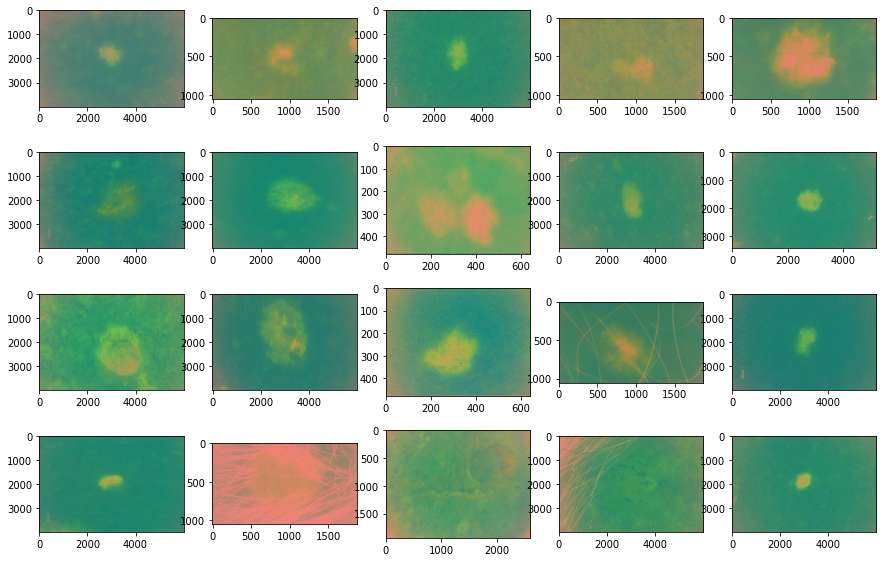

In [133]:
#showing the first 20 images
fig=plt.figure(figsize=(15, 10))
columns = 5; rows = 4
for i in range(1, columns*rows +1):
    ds = pydicom.dcmread(train_images_dir + train_images[i])
    fig.add_subplot(rows, columns, i)
    plt.imshow(-ds.pixel_array, cmap=plt.cm.bone)
    fig.add_subplot

Examples WITH Melanoma


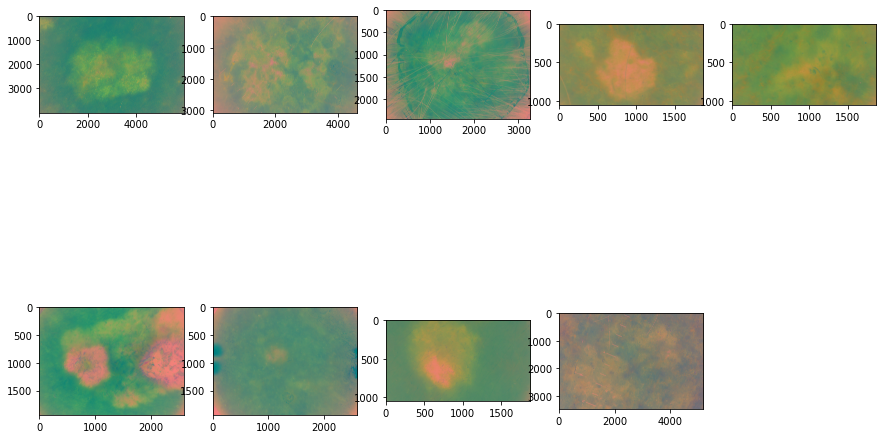

In [134]:
print('Examples WITH Melanoma')
imgs = df_train.loc[df_train.target==1].sample(10).image_name.values
fig=plt.figure(figsize=(15, 10))
columns = 5; rows = 2
for i in range(1, columns*rows ):
    ds = pydicom.dcmread(train_images_dir + imgs[i]+".dcm")
    fig.add_subplot(rows, columns, i)
    plt.imshow(-ds.pixel_array, cmap=plt.cm.bone)
    fig.add_subplot


Examples WITHout Melanoma


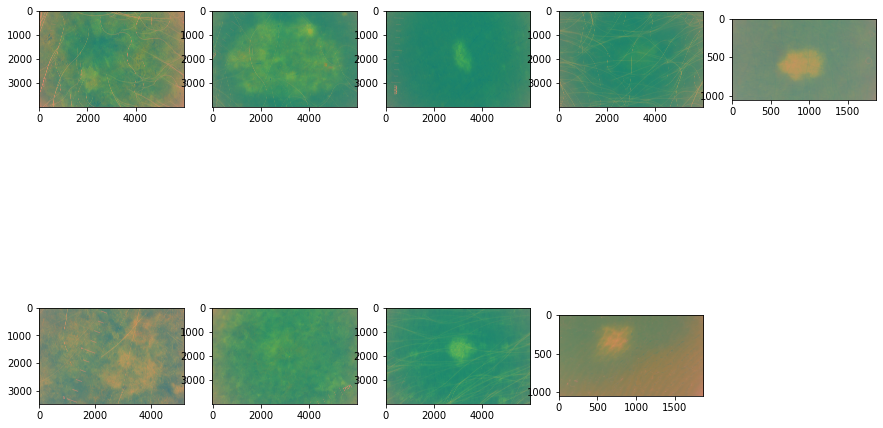

In [135]:
print('Examples WITHout Melanoma')
imgs = df_train.loc[df_train.target==0].sample(10).image_name.values
fig=plt.figure(figsize=(15, 10))
columns = 5; rows = 2
for i in range(1, columns*rows ):
    ds = pydicom.dcmread(train_images_dir + imgs[i]+".dcm")
    fig.add_subplot(rows, columns, i)
    plt.imshow(-ds.pixel_array, cmap=plt.cm.bone)
    fig.add_subplot


In [138]:
train_img_paths = df_train.path_jpeg.values

In [142]:
hair_images=glob('/kaggle/input/melanoma-hairs/*.png')
n_max=6     # the maximum number of hairs to augment
im_size=512  # all images are resized to this size
def hair_aug_ocv(input_img):
    
    img=input_img.copy()
    # Randomly choose the number of hairs to augment (up to n_max)
    n_hairs = random.randint(0, n_max)

    # If the number of hairs is zero then do nothing
    if not n_hairs:
        return img

    # The image height and width (ignore the number of color channels)
    im_height, im_width, _ = img.shape 

    for _ in range(n_hairs):

        # Read a random hair image
        hair = cv2.imread(random.choice(hair_images)) 
        
        # Rescale the hair image to the right size (256 -- original size)
        scale=im_size/256
        hair = cv2.resize(hair, (int(scale*hair.shape[1]), int(scale*hair.shape[0])), 
                          interpolation=cv2.INTER_AREA)       

        # Flip it
        # flipcode = 0: flip vertically
        # flipcode > 0: flip horizontally
        # flipcode < 0: flip vertically and horizontally    
        hair = cv2.flip(hair, flipCode=random.choice([-1, 0, 1]))

        # Rotate it
        hair = cv2.rotate(hair, rotateCode=random.choice([cv2.ROTATE_90_CLOCKWISE,
                                                          cv2.ROTATE_90_COUNTERCLOCKWISE,
                                                          cv2.ROTATE_180
                                                         ])
                         )
        
        
        # The hair image height and width (ignore the number of color channels)
        h_height, h_width, _ = hair.shape

        # The top left coord's of the region of interest (roi)  
        # where the augmentation will be performed
        roi_h0 = random.randint(0, im_height - h_height)
        roi_w0 = random.randint(0, im_width - h_width)

        # The region of interest
        roi = img[roi_h0:(roi_h0 + h_height), roi_w0:(roi_w0 + h_width)]

        # Convert the hair image to grayscale
        hair2gray = cv2.cvtColor(hair, cv2.COLOR_BGR2GRAY)

        # If the pixel value is smaller than the threshold (10), it is set to 0 (black), 
        # otherwise it is set to a maximum value (255, white).
        # ret -- the list of thresholds (10 in this case)
        # mask -- the thresholded image
        # The original image must be a grayscale image
        # https://docs.opencv.org/master/d7/d4d/tutorial_py_thresholding.html
        ret, mask = cv2.threshold(hair2gray, 10, 255, cv2.THRESH_BINARY)

        # Invert the mask
        mask_inv = cv2.bitwise_not(mask)

        # Bitwise AND won't be performed where mask=0
        img_bg = cv2.bitwise_and(roi, roi, mask=mask_inv)
        hair_fg = cv2.bitwise_and(hair, hair, mask=mask)
        # Fixing colors
        hair_fg = cv2.cvtColor(hair_fg, cv2.COLOR_BGR2RGB)

        # Overlapping the image with the hair in the region of interest
        dst = cv2.add(img_bg, hair_fg,dtype=cv2.CV_64F)
        
        # Inserting the result in the original image
        img[roi_h0:roi_h0 + h_height, roi_w0:roi_w0 + h_width] = dst
        
        
    return img
def aug_examples(paths):

    for img_path in paths:
        # Read the image
        img=cv2.imread(img_path)
        # Fixing colors
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Resize to the desired size
        img = cv2.resize(img , (im_size, im_size), interpolation = cv2.INTER_AREA )
        # Creating an augmented image
        img_aug = hair_aug_ocv(img)
        
        _, (ax1,ax2) = plt.subplots(1, 2)
        
        im_name=img_path.split('/')[-1].split('.')[0]    
        ax1.set_title(f"{im_name}")            
        #ax2.set_title(f"{im_name} with {n_hairs} {'hair' if n_hairs==1 else 'hairs'}")
        
        ax1.imshow(img)
        ax2.imshow(img_aug)
        
        plt.tight_layout()
        plt.show()

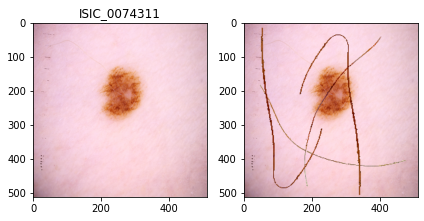

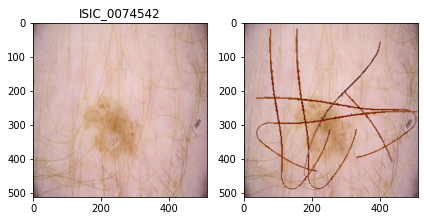

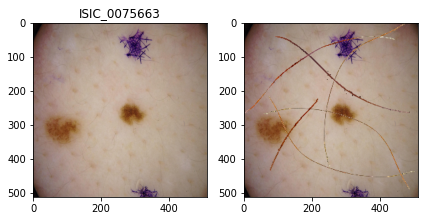

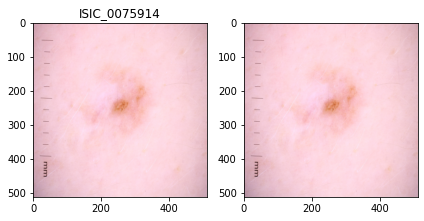

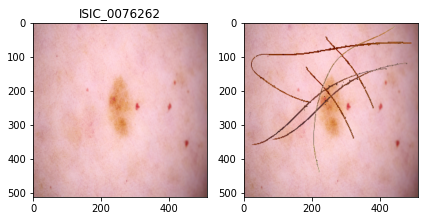

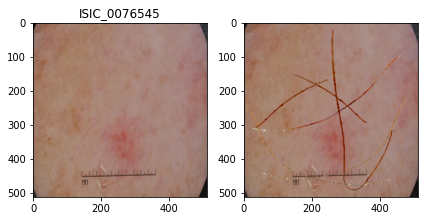

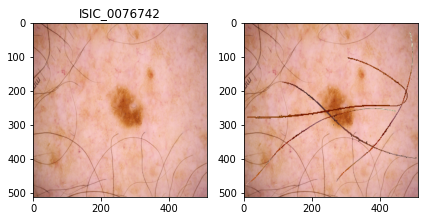

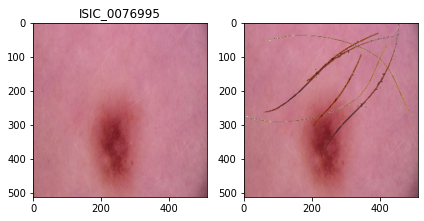

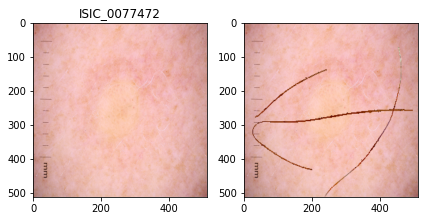

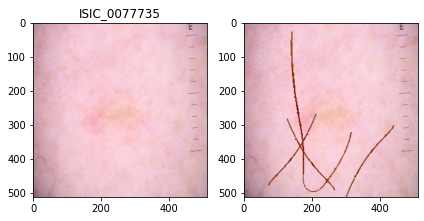

In [143]:
aug_examples(train_img_paths[5:15])

**Downsampling**

In [144]:
df_0=df_train[df_train['target']==0].sample(2000, ignore_index=True)
df_1=df_train[df_train['target']==1]
train=pd.concat([df_0,df_1])
train=train.reset_index(drop=True)
#train=train.drop(['index'], axis=1)

In [145]:
train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,target,n_images,path_jpeg
0,ISIC_8286826,IP_0400826,1,45.0,4,8,0,30,../input/siim-isic-melanoma-classification/jpe...
1,ISIC_1513596,IP_4639224,1,40.0,4,8,0,43,../input/siim-isic-melanoma-classification/jpe...
2,ISIC_2079417,IP_4419570,1,50.0,4,8,0,102,../input/siim-isic-melanoma-classification/jpe...
3,ISIC_5337614,IP_4788035,1,65.0,4,8,0,4,../input/siim-isic-melanoma-classification/jpe...
4,ISIC_1904481,IP_3562983,1,35.0,5,5,0,71,../input/siim-isic-melanoma-classification/jpe...


In [146]:
X_train, X_val, y_train, y_val = train_test_split(train.drop(['target'], axis=1),train['target'], test_size=0.2, random_state=1234)

In [147]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape) 

(2067, 8)
(517, 8)
(2067,)
(517,)


In [148]:
X_train_paths=X_train['path_jpeg']
X_val_paths=X_val['path_jpeg']
X_train_metadata=X_train.drop(['path_jpeg'], axis=1)
X_val_metadata=X_val.drop(['path_jpeg'], axis=1)

train=pd.DataFrame(X_train_paths)
train.columns=['images']
train['target']=y_train

validation=pd.DataFrame(X_val_paths)
validation.columns=['images']
validation['target']=y_val

In [149]:
train_datagen = ImageDataGenerator(preprocessing_function=hair_aug_ocv,
                                   rescale=1./255,
                                   rotation_range=50,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   zoom_range=0.3,
                                   shear_range=0.2, 
                                   fill_mode='nearest',
                                   vertical_flip=True
                                  )
val_datagen=ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    train,
    x_col='images',
    y_col='target',
    target_size=(512, 512),
    batch_size=8,
    shuffle=False,
    class_mode='raw')

validation_generator = val_datagen.flow_from_dataframe(
    validation,
    x_col='images',
    y_col='target',
    target_size=(512, 512),
    shuffle=False,
    batch_size=8,
    class_mode='raw')

Found 2067 validated image filenames.
Found 517 validated image filenames.


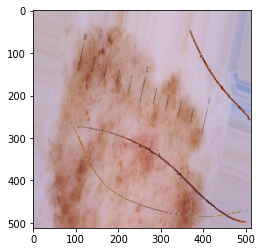

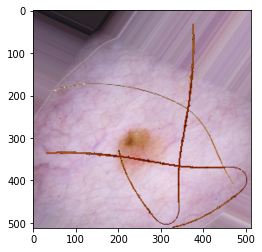

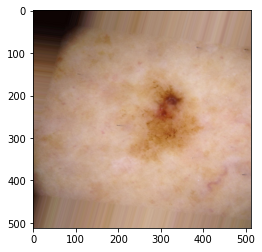

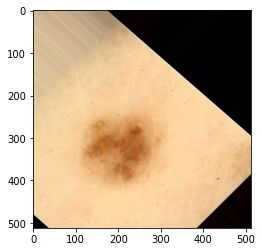

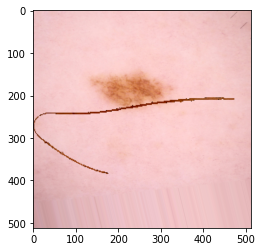

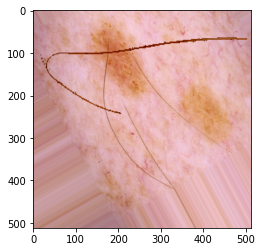

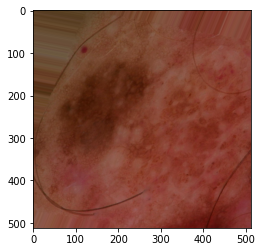

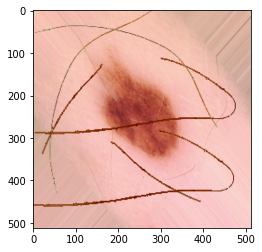

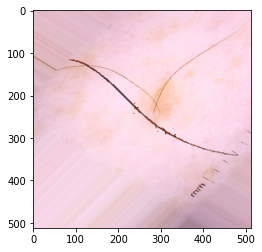

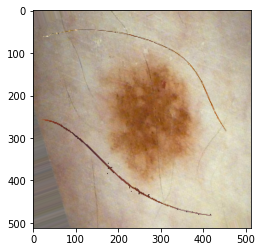

In [150]:
for _ in range(10):
     image, label = train_generator.next()
     # display the image from the iterator
     plt.imshow(image[0])
     #label_name=new_dict[label[0]] # note you are only showing the first image of the batch
     #plt.title(label_name)
     plt.show()

**Modeling**

**VGG Model (The highest accuracy)**

In [155]:
def vgg16_model( num_classes=None):

    model = VGG16(weights='imagenet', include_top=False, input_shape=(512, 512, 3))
    x=Flatten()(model.output)
    output=Dense(1,activation='sigmoid')(x) # because we have to predict the AUC
    model=Model(model.input,output)
    
    return model

vgg_conv=vgg16_model(1)

In [ ]:
def focal_loss(alpha=0.25,gamma=2.0):
    def focal_crossentropy(y_true, y_pred):
        bce = K.binary_crossentropy(y_true, y_pred)
        
        y_pred = K.clip(y_pred, K.epsilon(), 1.- K.epsilon())
        p_t = (y_true*y_pred) + ((1-y_true)*(1-y_pred))
        
        alpha_factor = 1
        modulating_factor = 1

        alpha_factor = y_true*alpha + ((1-alpha)*(1-y_true))
        modulating_factor = K.pow((1-p_t), gamma)

        # compute the final loss and return
        return K.mean(alpha_factor*modulating_factor*bce, axis=-1)
    return focal_crossentropy

In [156]:
opt = Adam(lr=1e-5)
vgg_conv.compile(loss = 'binary_crossentropy', metrics=[tf.keras.metrics.AUC()],optimizer=opt)

In [157]:
nb_epochs = 2
batch_size=8
nb_train_steps = train.shape[0]//batch_size
nb_val_steps=validation.shape[0]//batch_size
print("Number of training and validation steps: {} and {}".format(nb_train_steps,nb_val_steps))

Number of training and validation steps: 258 and 64


In [158]:
#cb=[PlotLossesKeras()]
vgg_conv.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_steps,
    epochs=nb_epochs,
    validation_data=validation_generator,
    #callbacks=cb,
    validation_steps=nb_val_steps)

Epoch 1/2
258/258 [==============================] - 605s 2s/step - loss: 0.5176 - auc_1: 0.6028 - val_loss: 0.5989 - val_auc_1: 0.7410
Epoch 2/2
258/258 [==============================] - 595s 2s/step - loss: 0.4831 - auc_1: 0.7004 - val_loss: 0.4550 - val_auc_1: 0.8212


**Efficientnetb0 Model**

****

In [159]:
from tensorflow.keras.layers import Dense
#import efficientnet.tfkeras as efn
#Defining the model

efficientnetb0_model = tf.keras.Sequential([
    EfficientNetB0(
        input_shape=(512,512, 3),
        #weights='imagenet',
        weights='imagenet',
        include_top=False
    ),
    L.GlobalAveragePooling2D(),
    L.Dense(1024, activation = 'relu'), 
    L.Dropout(0.3), 
    L.Dense(512, activation= 'relu'), 
    L.Dropout(0.2), 
    L.Dense(256, activation='relu'), 
    L.Dropout(0.2), 
    L.Dense(128, activation='relu'), 
    L.Dropout(0.1), 
    L.Dense(1, activation='sigmoid')
])

In [160]:
from tensorflow.keras import backend as K

def focal_loss(gamma=2., alpha=.25):
	def focal_loss_fixed(y_true, y_pred):
		pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
		pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
		return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
	return focal_loss_fixed

In [161]:
efficientnetb0_model.compile(
    optimizer='Adam',
    loss = focal_loss(gamma=2., alpha=.25),
    #loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.1),
    metrics=['binary_crossentropy', 'accuracy']
)
efficientnetb7_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 16, 16, 1280)      4049571   
_________________________________________________________________
global_average_pooling2d_7 ( (None, 1280)              0         
_________________________________________________________________
dense_37 (Dense)             (None, 1024)              1311744   
_________________________________________________________________
dropout_28 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_38 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_29 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 256)              

In [162]:
efficientnetb7_model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_steps,
    epochs=nb_epochs,
    validation_data=validation_generator,
    #class_weight = {0:0.50899675,1: 28.28782609},
    validation_steps=nb_val_steps
    
)

Epoch 1/2
258/258 [==============================] - 575s 2s/step - loss: 0.0573 - binary_crossentropy: 0.5142 - accuracy: 0.7761 - val_loss: 0.0639 - val_binary_crossentropy: 0.5645 - val_accuracy: 0.7500
Epoch 2/2
258/258 [==============================] - 561s 2s/step - loss: 0.0557 - binary_crossentropy: 0.5175 - accuracy: 0.7795 - val_loss: 0.0562 - val_binary_crossentropy: 0.5633 - val_accuracy: 0.7500


In [163]:
submission=pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/sample_submission.csv')
vgg_predict=pd.read_csv('/kaggle/working/submission_images.csv')

In [ ]:
target=[]
for path in df_test['path_jpeg']:
    img=cv2.imread(str(path))
    img = cv2.resize(img, (512,512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    img=np.reshape(img,(1,512,512,3))
    prediction=vgg_conv.predict(img)
    target.append(prediction[0][0])

submission['target']=target

In [ ]:
submission.to_csv('submission_images.csv', index=False)
submission.head()


In [172]:
df_train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,target,n_images,path_jpeg
0,ISIC_2637011,IP_7279968,1,45.0,0,8,0,115,../input/siim-isic-melanoma-classification/jpe...
1,ISIC_0015719,IP_3075186,0,45.0,5,8,0,24,../input/siim-isic-melanoma-classification/jpe...
2,ISIC_0052212,IP_2842074,0,50.0,1,5,0,5,../input/siim-isic-melanoma-classification/jpe...
3,ISIC_0068279,IP_6890425,0,45.0,0,8,0,22,../input/siim-isic-melanoma-classification/jpe...
4,ISIC_0074268,IP_8723313,0,55.0,5,8,0,20,../input/siim-isic-melanoma-classification/jpe...


**Using tabular data and images**

In [174]:
L = 15
feat = ['sex','age_approx','anatom_site_general_challenge','n_images']

M = df_train.target.mean()
te = df_train.groupby(feat)['target'].agg(['mean','count']).reset_index()
te['ll'] = ((te['mean']*te['count'])+(M*L))/(te['count']+L)
del te['mean'], te['count']

test = df_test.merge( te, on=feat, how='left' )
test['ll'] = test['ll'].fillna(M)

test.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,n_images,path_jpeg,ll
0,ISIC_0052060,IP_3579794,1,70.0,4,240,../input/siim-isic-melanoma-classification/jpe...,0.017630
1,ISIC_0052349,IP_7782715,1,40.0,1,46,../input/siim-isic-melanoma-classification/jpe...,0.017630
2,ISIC_0058510,IP_7960270,0,55.0,4,28,../input/siim-isic-melanoma-classification/jpe...,0.005085
3,ISIC_0073313,IP_6375035,0,50.0,4,38,../input/siim-isic-melanoma-classification/jpe...,0.011498
4,ISIC_0073502,IP_0589375,0,45.0,1,29,../input/siim-isic-melanoma-classification/jpe...,0.015556


In [177]:
sub = vgg_predict.copy()
sub.target = 0.9 * vgg_predict.target.values + 0.1 * test.ll.values
sub.to_csv('submission_images_labels.csv',index=False)


In [178]:
sub.head()

,image_name,target
0,ISIC_0052060,0.029882
1,ISIC_0052349,0.026791
2,ISIC_0058510,0.023745
3,ISIC_0073313,0.020337
4,ISIC_0073502,0.106244
